In [2]:
import os
import sys
import json
from pathlib import Path
sys.path.append(os.path.abspath('..'))

# ----------- local imports ----------- 
from constants import FACE_ID_TRAIN_PATH, DATA_DIR
from Facenet.face_id_dataset import load_faces_in_batch

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
import pandas as pd
import numpy as np

2025-03-13 23:53:35.951773: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-13 23:53:35.990650: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-13 23:53:36.002904: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-13 23:53:36.072201: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-13 23:53:38.091040: W tensorflow/compiler/tf2

In [3]:
# preprocess train embedding dataframe
df_train_embeddings = pd.read_csv("embeddings/train_embeddings.csv")
# fix embeddings to np array
df_train_embeddings['embeddings'] = df_train_embeddings['embeddings'].apply(lambda x: np.array(x[1:-1].split(), dtype=np.float32))
# add person as column
df_train_embeddings['person'] = df_train_embeddings['identity'].apply(lambda p: Path(p).parent.name)
# add image name as column `img`
df_train_embeddings['img'] = df_train_embeddings['identity'].apply(lambda p: Path(p).name)
# drop whole path `identity` column
df_train_embeddings = df_train_embeddings.drop(['identity'], axis=1)

In [4]:
df_train_embeddings['person'].value_counts().describe()

count    125.000000
mean      54.624000
std       41.373917
min        5.000000
25%       30.000000
50%       49.000000
75%       68.000000
max      283.000000
Name: count, dtype: float64

# Split Train set to Validation

In [5]:
df = df_train_embeddings.copy()

In [6]:
# 1. get random people
np.random.seed(1710)
rand_people_index = np.random.randint(0, 124 + 1, 5)

rand_peple_mask = df['person'].apply(lambda x: int(x.split('_')[1]) in rand_people_index)

# make train set without it
train_df = df[~rand_peple_mask].copy()

# make validation set with it
val_df =  df[rand_peple_mask].copy()
val_df['gt'] = "doesn't_exist"
# remove it from train
rand_people_index

array([ 43, 121,  89, 113,  72])

foreach person sample percentage(0.2) of images for validation set

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

In [8]:
X = train_df.index
y = train_df['person']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, val_idx in sss.split(X, y):
    v = train_df.iloc[val_idx].copy()
    v['gt'] = v['person']
    val_df = pd.concat([val_df, v])
    #
    train_df = train_df.iloc[train_idx].copy()

In [9]:
len(train_df['person'].unique()), len(val_df['person'].unique())

(120, 125)

by random select 5 people to go to validation set

In [10]:
# train_df['person'].value_counts().describe()
# val_df['person'].value_counts().describe()

In [11]:
len(val_df) / len(df) * 100

21.924428822495607

In [12]:
len(train_df) / len(df) * 100

78.07557117750439

In [13]:
# check no repeated item
val_df.set_index('img').join(train_df.set_index('img'), lsuffix='l').isna()['person'].all()

True

# Testing FaceNet on them

In [14]:
def calculate_cosine_similarity(input_embeddings, df = train_df, batch_size = 64):
    input_embeddings = input_embeddings.reshape(-1, 1) # embedding_size x 1
    input_embeddings /= np.linalg.norm(input_embeddings) # normalize embedding for cos calculations
    
    # store result in dataframe
    results_df = df.copy()
    cosine_similarities = np.zeros(len(df))
    # loop on df by batchs
    for i in range(0, len(df), batch_size):
        batch = df.iloc[i:i+batch_size]
        
        batch_embeddings = np.vstack(batch['embeddings'].values) # batch_size x embedding_size
        batch_embeddings /= np.linalg.norm(batch_embeddings, axis=1, keepdims=True)
        
        result = np.dot(batch_embeddings, input_embeddings).reshape(-1,)
        cosine_similarities[i:i+batch_size] = result 
    
    results_df['cosine_similarity'] = cosine_similarities
    return results_df

In [15]:
get_img_by_name = lambda img_name: Image.open(next(iter(FACE_ID_TRAIN_PATH.rglob(img_name))))

def plot_sample_top_results(sample, ntop = 5):
    sample_img = get_img_by_name(sample['img'])
    results = calculate_cosine_similarity(sample['embeddings'], train_df)
    
    top_n = results.sort_values(by='cosine_similarity').tail(ntop)
    
    # Plot 6 images (1 sample + 5 most similar)
    fig, axes = plt.subplots(1, ntop+1, figsize=(18, 5))

    # Plot the sample image
    axes[0].imshow(sample_img)
    axes[0].set_title(f"Sample Image, {sample['gt']}")
    axes[0].axis("off")

    # Plot the top 5 similar images
    for i, row in enumerate(top_n.iterrows()):
        img = get_img_by_name(row[1]['img'])
        
        axes[i + 1].imshow(img)
        axes[i + 1].set_title(f"Sim: {row[1]['cosine_similarity']:.2f}, {row[1]['person']}")
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()
    
    return results

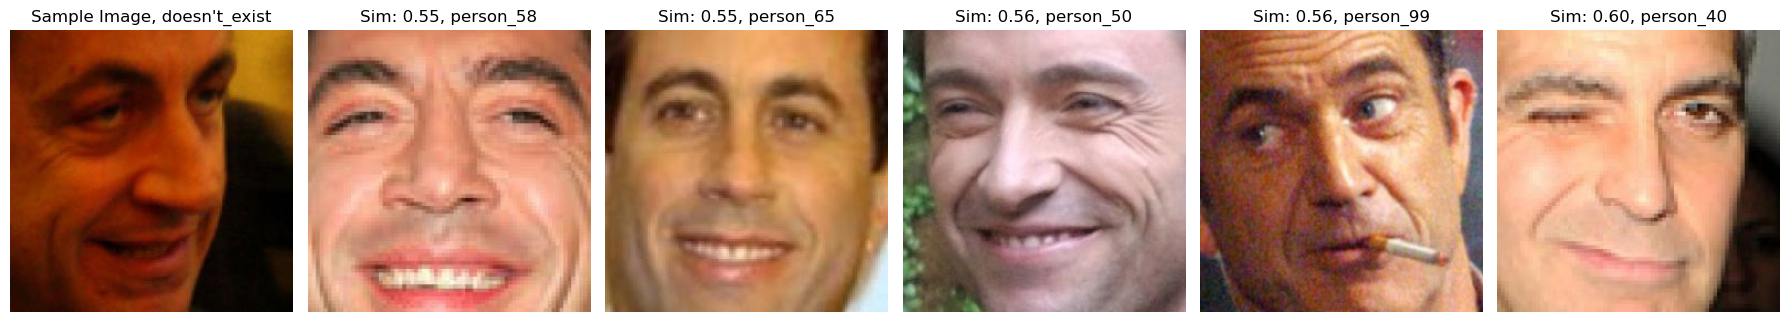

In [16]:
r = plot_sample_top_results(val_df.iloc[0])

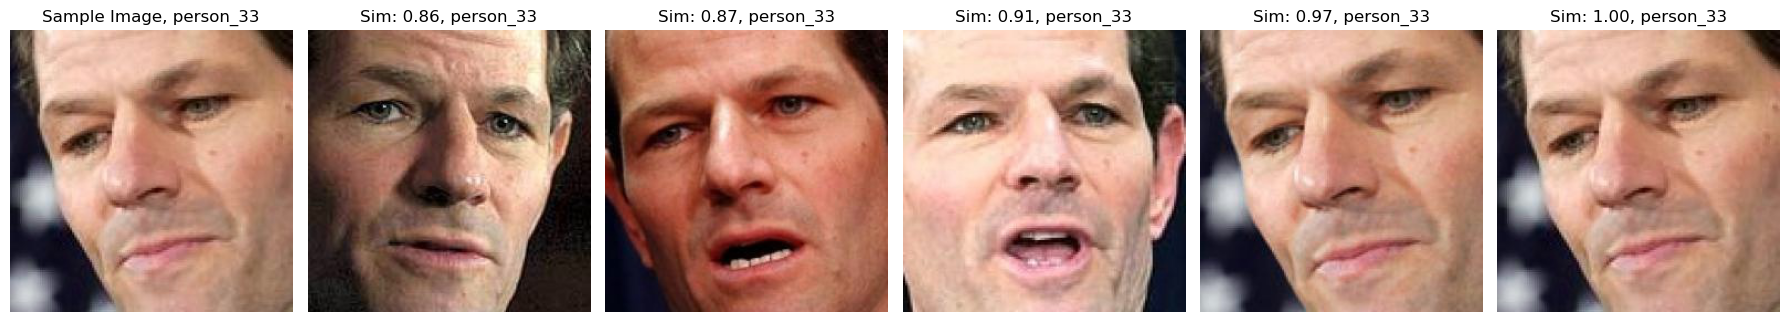

In [17]:
r = plot_sample_top_results(val_df.iloc[205])

In [162]:
# [ 43, 121,  89, 113,  72]

# Calculate Accuracy for Validation set

In [18]:
from sklearn.metrics import accuracy_score

In [19]:
y = list(val_df['gt'].values)

In [20]:

thresholds = [0.6, 0.62, 0.65, 0.68, 0.7]
results = []

for th in tqdm(thresholds):
    y_pred = []
    for i, row in tqdm(val_df.iterrows(), total=len(val_df)):
        top_similar = calculate_cosine_similarity(row['embeddings'], batch_size=512).nlargest(1, 'cosine_similarity').iloc[0]
        if top_similar['cosine_similarity'] >= th:
            y_pred.append(top_similar['person'])
        else:
            y_pred.append("doesn't_exist")

    result = {'th': th, 'acc': accuracy_score(y, y_pred), 'y_pred': y_pred}
    results.append(result)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1497 [00:00<?, ?it/s]

  0%|          | 0/1497 [00:00<?, ?it/s]

  0%|          | 0/1497 [00:00<?, ?it/s]

  0%|          | 0/1497 [00:00<?, ?it/s]

  0%|          | 0/1497 [00:00<?, ?it/s]

In [175]:
pd.DataFrame(results).sort_values(by='acc', ascending=False)

th       acc                                             y_pred
2  0.65  0.946560  [doesn't_exist, doesn't_exist, doesn't_exist, ...
1  0.62  0.945224  [doesn't_exist, doesn't_exist, doesn't_exist, ...
3  0.68  0.941884  [doesn't_exist, doesn't_exist, doesn't_exist, ...
0  0.60  0.932532  [person_40, person_99, doesn't_exist, doesn't_...
4  0.70  0.929860  [doesn't_exist, doesn't_exist, doesn't_exist, ...

## Investigate Errors

In [191]:
best_y_pred = pd.DataFrame(results).sort_values(by='acc', ascending=False).iloc[0]['y_pred']

# accuracy_score(y, best_y_pred) * len(y)

misclassified_indices = [i for i, (true, pred) in enumerate(zip(y, best_y_pred)) if true != pred]
misclassified_samples = val_df.reset_index().iloc[misclassified_indices]

In [ ]:
misclassified_samples['gt'].value_counts()

gt
doesn't_exist    23
person_45         4
person_90         3
person_78         3
person_70         3
person_11         2
person_83         2
person_57         2
person_75         2
person_9          2
person_63         2
person_36         1
person_41         1
person_85         1
person_7          1
person_106        1
person_98         1
person_24         1
person_119        1
person_51         1
person_117        1
person_19         1
person_122        1
person_47         1
person_105        1
person_5          1
person_52         1
person_69         1
person_96         1
person_40         1
person_79         1
person_62         1
person_109        1
person_53         1
person_66         1
person_30         1
person_17         1
person_91         1
person_10         1
person_80         1
person_16         1
person_124        1
person_15         1
Name: count, dtype: int64

In [204]:
(misclassified_samples['gt'] != "doesn't_exist").sum()

57

In [201]:
# misclassified_samples['gt'].value_counts()
misclassified_samples['gt']

24      doesn't_exist
27      doesn't_exist
77      doesn't_exist
79      doesn't_exist
81      doesn't_exist
            ...      
1372        person_19
1376       person_122
1407        person_47
1428       person_105
1444        person_15
Name: gt, Length: 80, dtype: object

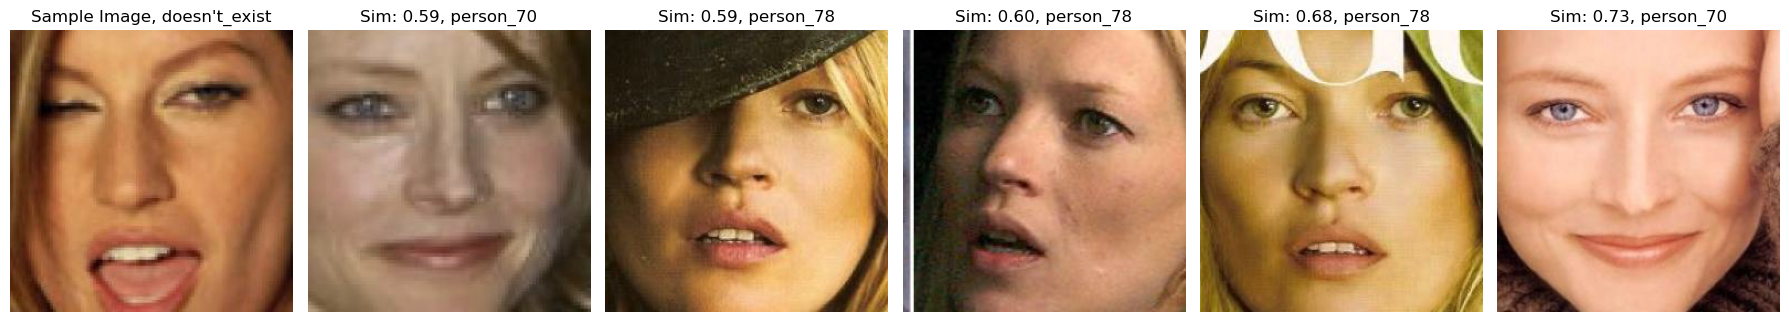

In [21]:
# r = plot_sample_top_results(val_df.iloc[24])
r = plot_sample_top_results(val_df.iloc[81])

In [22]:
rtop = r.nlargest(10, 'cosine_similarity')
rtop.groupby('person').sum()['cosine_similarity'] / rtop['cosine_similarity'].sum()

person
person_42    0.185987
person_70    0.219560
person_78    0.594454
Name: cosine_similarity, dtype: float64

In [23]:
rtop

embeddings     person       img  \
4897  [-1.253459, 0.3397505, -1.4159892, -0.43917128...  person_70  6973.jpg   
5233  [-2.0259252, 2.0779533, -0.9363154, -1.2026091...  person_78  7448.jpg   
5249  [-1.4886274, 0.8208103, -0.04927759, -0.135057...  person_78  7473.jpg   
5235  [-2.5035217, 2.2294922, -1.178092, 0.33123448,...  person_78  7450.jpg   
4896  [-0.75612015, -0.61251616, -0.6952221, 0.41229...  person_70  6972.jpg   
5243  [-1.7476165, 1.0768312, -1.4295771, -1.4198351...  person_78  7463.jpg   
5232  [-0.6950201, 1.0628453, -1.1542852, -0.7147884...  person_78  7446.jpg   
3313  [-0.8177481, 1.2973071, 1.2731589, -0.6742764,...  person_42  4729.jpg   
3324  [-1.1179605, 1.6723679, 0.85912263, 0.03027754...  person_42  4744.jpg   
5238  [-2.1879027, 1.0062149, -1.3029109, 0.12053492...  person_78  7453.jpg   

      cosine_similarity  
4897           0.730942  
5233           0.679679  
5249           0.599384  
5235           0.594836  
4896           0.591246  
5243           0.587850  
5232           0.566716  
3313           0.561298  
3324           0.558715  
5238           0.551334

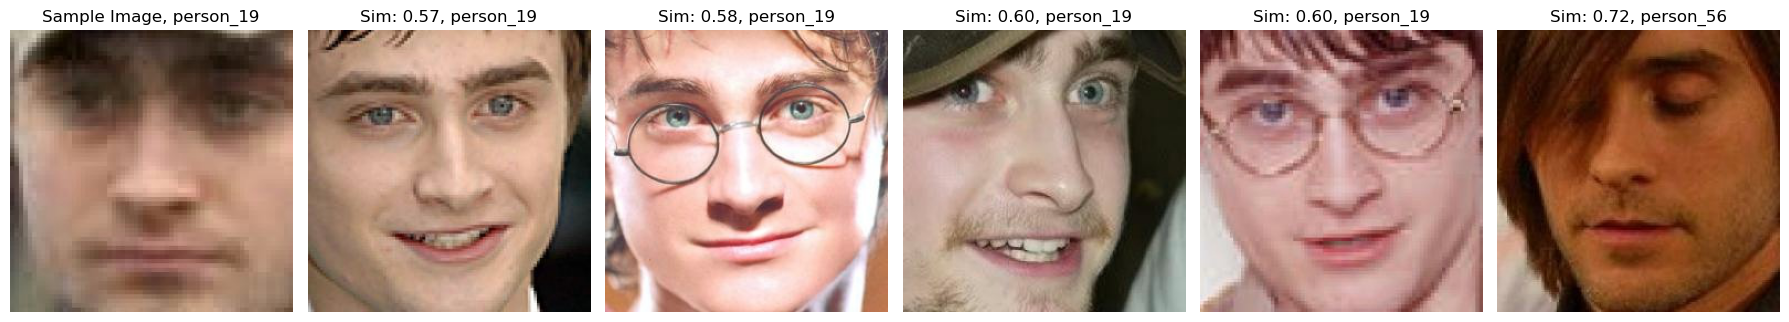

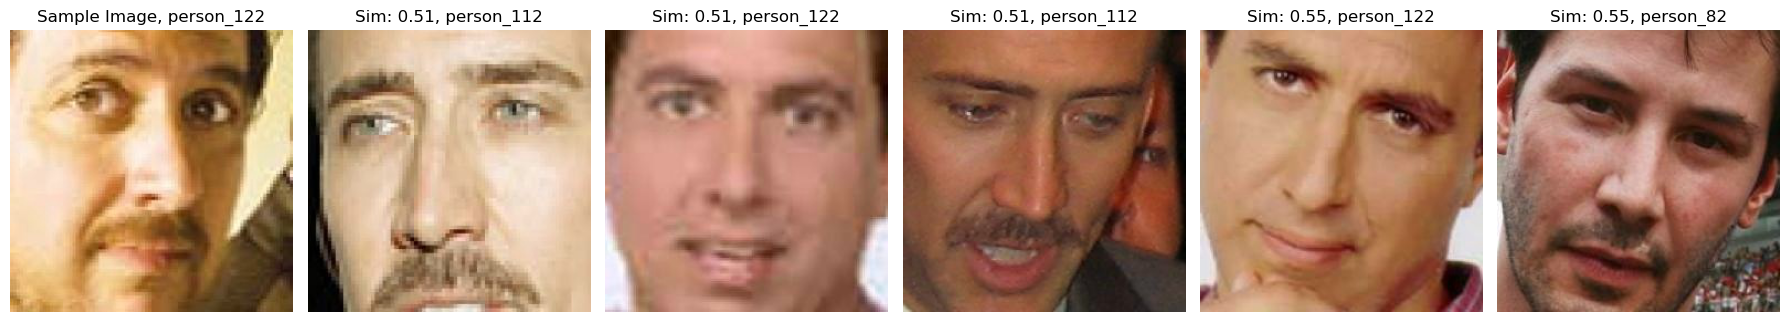

In [215]:
# 25irn m4kola tt7l :>
r = plot_sample_top_results(val_df.iloc[1372])
r = plot_sample_top_results(val_df.iloc[1376])

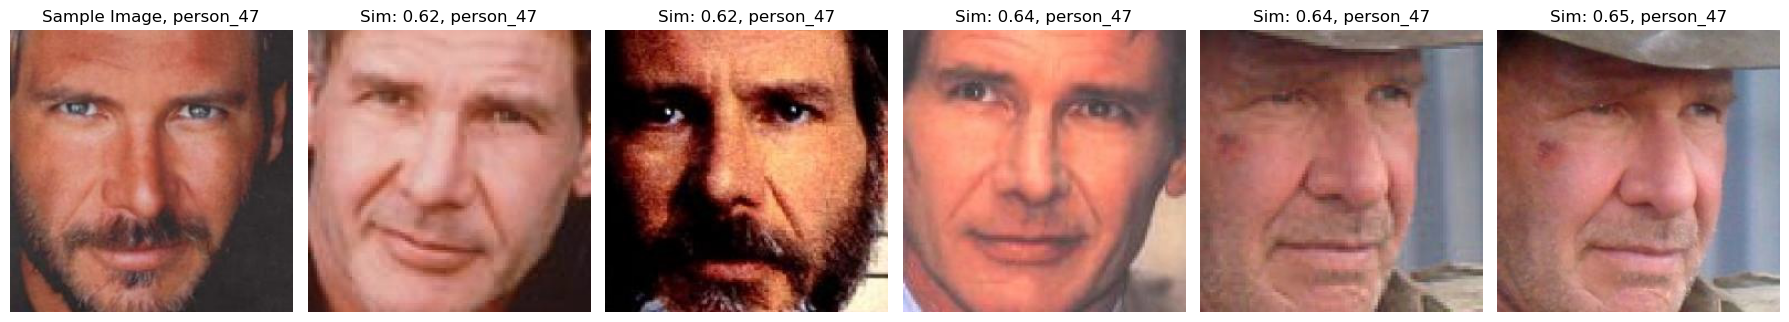

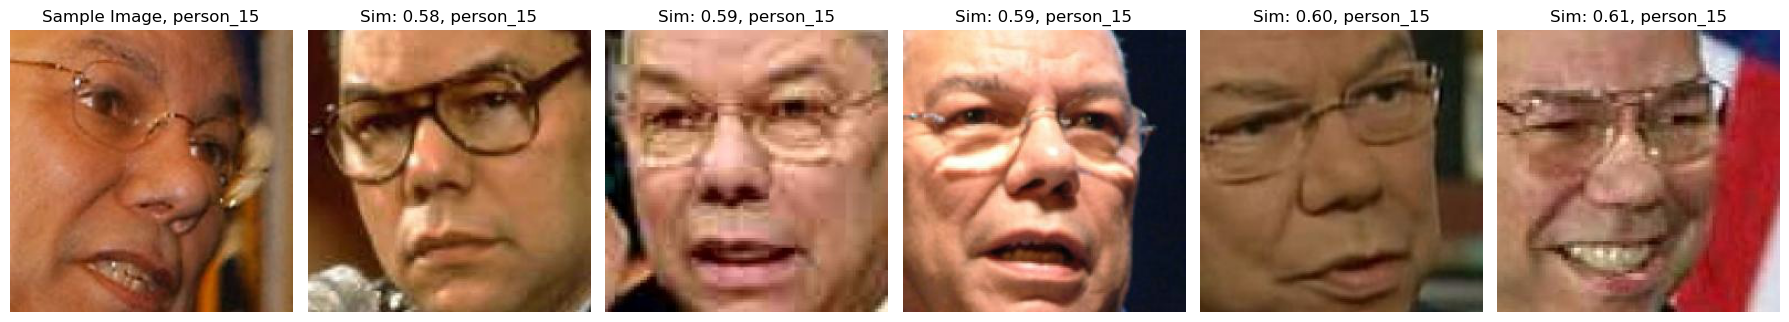

In [ ]:
# threshold mistake  I think could be solved using voting
r = plot_sample_top_results(val_df.iloc[1407])
r = plot_sample_top_results(val_df.iloc[1444])  

In [102]:
r[r['person'] == 'person_72']

Empty DataFrame
Columns: [embeddings, person, img, cosine_similarity]
Index: []

In [106]:
train_df[train_df['person'] == 'person_72']

Empty DataFrame
Columns: [embeddings, person, img]
Index: []

# Voting Accuracy

In [49]:
results = []

thresholds = [0.6, 0.62, 0.65, 0.68, 0.7]

for th in tqdm(thresholds):
    y_pred = []
    for i, row in tqdm(val_df.iterrows(), total=len(val_df)):
        top_similar = calculate_cosine_similarity(row['embeddings'], batch_size=512).nlargest(5, 'cosine_similarity')

        top_people = top_similar.groupby('person').sum()['cosine_similarity'] / top_similar['cosine_similarity'].sum()

        top_person = top_people.nlargest().index[0]
        top_similary = top_people.nlargest().iloc[0]
        
        if top_similary >= th:
            y_pred.append(top_person)
        else:
            y_pred.append("doesn't_exist")
            
    result = {'th': th, 'acc': accuracy_score(y, y_pred), 'y_pred': y_pred}
    results.append(result)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1497 [00:00<?, ?it/s]

  0%|          | 0/1497 [00:00<?, ?it/s]

  0%|          | 0/1497 [00:00<?, ?it/s]

  0%|          | 0/1497 [00:00<?, ?it/s]

  0%|          | 0/1497 [00:00<?, ?it/s]

In [50]:
pd.DataFrame(results)

th       acc                                             y_pred
0  0.60  0.931196  [doesn't_exist, doesn't_exist, person_99, does...
1  0.62  0.943888  [doesn't_exist, doesn't_exist, doesn't_exist, ...
2  0.65  0.943888  [doesn't_exist, doesn't_exist, doesn't_exist, ...
3  0.68  0.943220  [doesn't_exist, doesn't_exist, doesn't_exist, ...
4  0.70  0.943220  [doesn't_exist, doesn't_exist, doesn't_exist, ...

In [47]:
accuracy_score(y, y_pred)

0.9438877755511023

# 